In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Autosaving every 180 seconds


In [2]:
import importlib
import sys
sys.path.append('../../')
import src
importlib.reload(src)

<module 'src' (namespace)>

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as anm
import numpy as np
from scipy.io import loadmat, savemat
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils
import src.eikonal as eikonal
# import src.openst.OpenST as ost
import timeit
from tqdm import tqdm_notebook
from scipy.ndimage import gaussian_filter

Using TensorFlow backend.


In [5]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.backend import tf
# import tensorflow as tf
from keras.engine.topology import Layer
import keras
from keras.constraints import NonNeg, MinMaxNorm
from IPython.display import clear_output

## Model with 2 layers (low, high)

In [6]:
nx, nz = 51, 51
xmin, xmax = 0, 1000
zmin, zmax = 0, 1000
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
X, Z = np.meshgrid(x, z, indexing='ij')

vmin, vmax = 3000.0, 2000.0
izc = 25
V = np.full_like(Z, vmin)
V[:, izc:] = vmax
# V = gaussian_filter(V, 3)

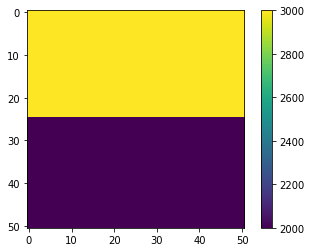

In [5]:
plt.imshow(V.T)
plt.colorbar()

In [7]:
ixs, izs = 10, 10
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
V_scaled = V / V.max()
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler

R = np.linalg.norm(np.stack([X_scaled, Z_scaled], axis=-1), axis=-1)
B = eikonal.get_bounds(X_scaled, ixs, izs, neighbours=False, V=V_scaled, Z=Z_scaled)

In [15]:
data_inhomo = eikonal.prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_scaled.ravel(), B.ravel()], 
                             ['input_x', 'input_y', 'velocity', 'bounds'])

In [33]:
CoordLimLow = np.array([xmin, zmin])
CoordLimHigh = np.array([xmax, zmax])
GridSize = np.array([nx, nz])
GridStep = (CoordLimHigh - CoordLimLow) / (GridSize - 1)

T_FSM = ost.LSM2D(V, CoordLimLow, CoordLimHigh, GridStep, sou)

In [20]:
dx = x[1] - x[0]
dz = z[1] - z[0]
grad_x, grad_z = np.gradient(T_FSM, dx, dz)
grad = np.stack([grad_x, grad_z], axis=-1)

grad_norm = grad / np.linalg.norm(grad, axis=-1, keepdims=True) + 1e-16

data_inhomo = eikonal.prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_scaled.ravel(), B.ravel(), T_FSM], 
                             ['input_x', 'input_y', 'velocity', 'out', 'true'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


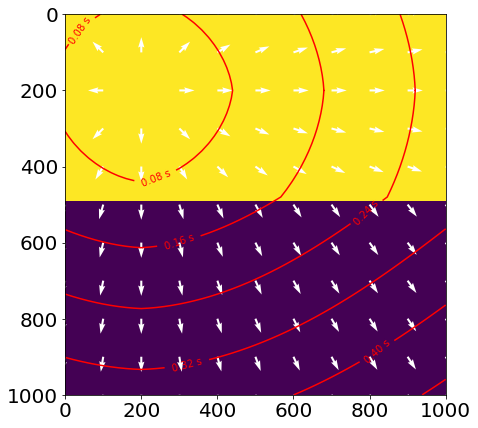

In [35]:
step = 5

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_ = grad_norm[::step, ::step, 0]
V_ = -grad_norm[::step, ::step, 1]

plt.figure(figsize=(15,10))

extent=(xmin, xmax, zmin, zmax)

plt.subplot(121)
plt.imshow(V.T, extent=(xmin, xmax, zmax, zmin))
cs = plt.contour(T_FSM.T, colors='r', extent=extent)
# plt.colorbar(mappable=img, ax=ax, fraction=1/22)
plt.clabel(cs, cs.levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
plt.ylim([zmax, zmin])
plt.quiver(X_, Z_, U_, V_, scale=25, color='white')
plt.axis('scaled')

plt.show()

In [22]:
step_i, step_j = 1, 1

data, indices = eikonal.expansion_batches(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=step_i, step_j=step_j, start=1, enhance=False, freq=1)

data_f, indices_f = eikonal.expansion_fronts(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=step_i, step_j=step_j)

In [26]:
models = eikonal.forward_model(nh=50, layers=3, shape=(1,), activation='tanh', act_constraints=None, lr=1e-3, decay=1e-5,
                               init='glorot_normal', Blambda=2.0, Mlambda=2.0, Llambda=0.0, Plambda=0.0, monotonity_dxy=False, 
                               inversion=False)

model_time, model_grad, model_E, model_B, model_M, model_L, model_P = models
model_E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_y (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 2)            0           input_x[0][0]                    
                                                                 input_y[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 50)           150         concatenate_6[0][0]              
__________

1296
MAE = 1140.846 ms, -114.05 %


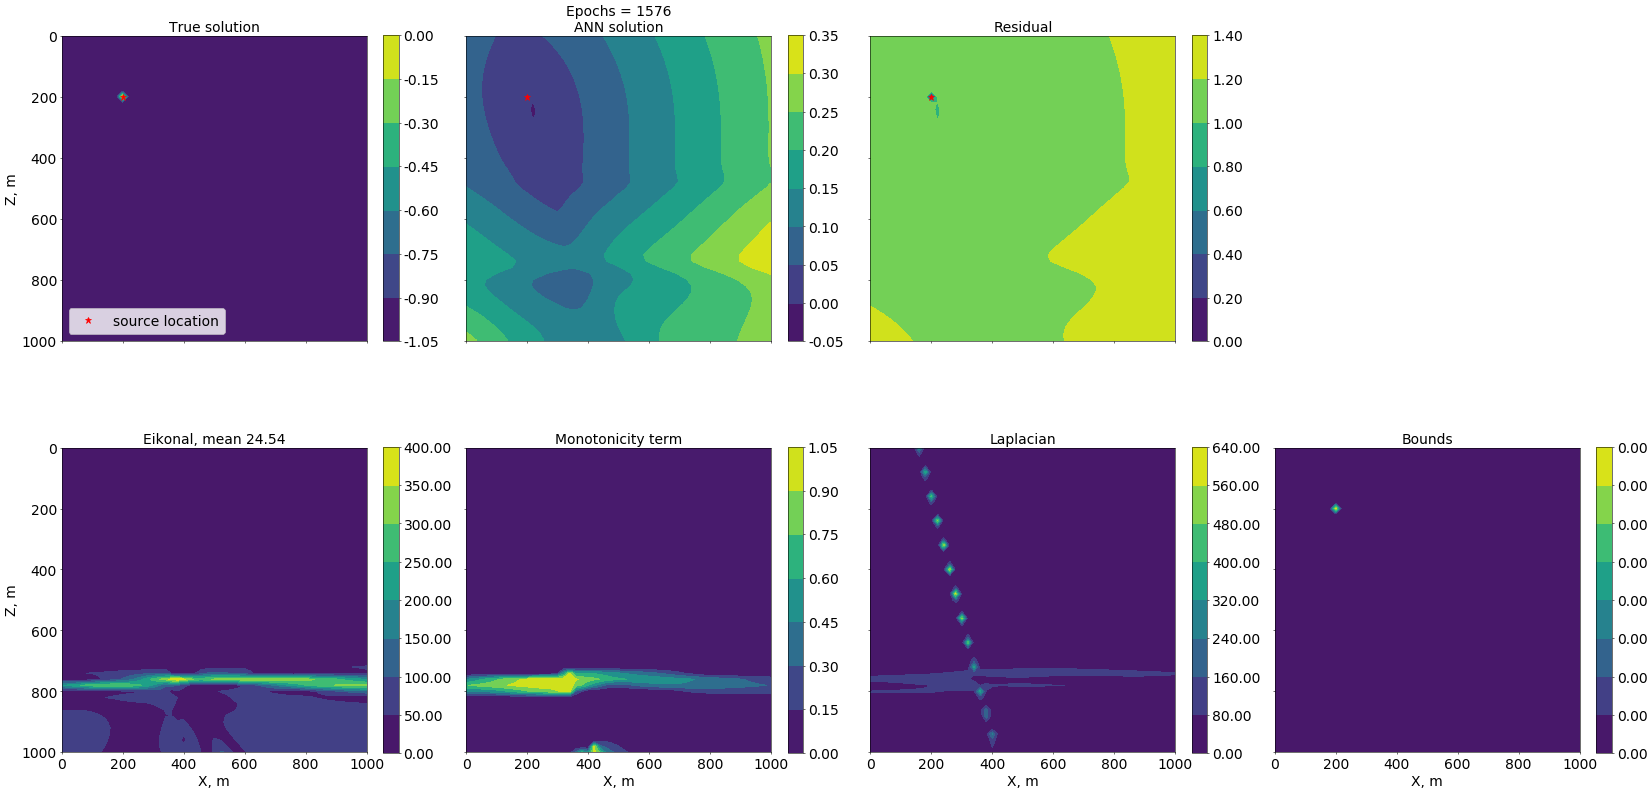

KeyboardInterrupt: 

In [27]:
%%time
input_test = data_inhomo
T_true = B
data_train = data

K = len(data_train)
epochs = np.linspace(2500, 1000, K, dtype=int)

for i in range(0, K):
    input_train = data_train[i]
    output_train = data_train[i]['bounds']
    batch_size = len(output_train)


    model_E.fit(
        input_train, 
        output_train, 
        batch_size=batch_size,
        epochs=epochs[i],
        shuffle=False,
        validation_split=.0,
        verbose=0,
#         callbacks=[reducer]
    )

    clear_output(wait=True)
    T_pred = model_time.predict(input_test) / V.max() * scaler
    T_pred_2d = T_pred.reshape(T_true.shape)
#     T_pred_2d -= T_pred_2d[ixs, izs]
    print(batch_size)
    MAE = abs(T_pred_2d - T_true)
    rMAE = MAE / (T_true + 1e-16) * 100
    if rMAE[ixs, izs] != 0.0:
        rMAE[ixs, izs] = 100
    
    eik = model_E.predict(input_test).reshape(T_true.shape)
    eik_r = abs(eik) * V_scaled**2 * 100
    dot_term = model_M.predict(input_test).reshape(T_true.shape)
    laplacian = model_L.predict(input_test).reshape(T_true.shape)
    bounds = model_B.predict(input_test).reshape(T_true.shape)
    
    print('MAE = {0:.3f} ms, {1:.2f} %'.format(MAE.mean() * 1000, rMAE.mean()))
    fig, axes = plot_utils.plot_images(imgs=[[T_true.T, T_pred_2d.T, MAE.T, None], [eik_r.T, dot_term.T, laplacian.T, bounds.T]], 
                            cols_names=[['True solution', 'Epochs = {}\nANN solution'.format(epochs[i]), 'Residual'], 
                                         ['Eikonal, mean {0:.2f}'.format(eik_r.mean()), 'Monotonicity term', 'Laplacian', 'Bounds']], 
                            sources=[[sou, sou, sou], [None]], extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (40, 20),  
                            fontsize=20, imshows=False, colorbars=True)
    
#     for j in [1,]:
#         axes[0,j].plot(np.take(x, indices_f[i])[:,0], np.take(z, indices_f[i])[:,1], '.k')
#         axes[0,j].plot(sou[0], sou[1], '*r', ms=10)
    

    plt.show()

In [27]:
model_t.save('../nn_models/model_t_layers_low')
model_eikonal.save('../nn_models/model_eikonal_layers_low')
model_vectorfield.save('../nn_models/model_vectorfield_layers_low')

In [41]:
np.save('../data/fsm_layers_low', T_FSM)

In [24]:
T_FSM = np.load('../data/fsm_layers_low.npy')

In [28]:
fsm_grad = np.array(np.gradient(T_FSM, dx, dz))
fsm_modul = np.linalg.norm(fsm_grad, axis=-1, keepdims=True) + 1e-16
fsm_grad_norm = fsm_grad / fsm_modul

pred_grad = model_vectorfield.predict(input_test) / V.max()
pred_grad = pred_grad.reshape(T_pred_2d.shape + (2,))
pred_modul = np.linalg.norm(pred_grad, axis=-1, keepdims=True) + 1e-16
pred_grad_norm = pred_grad / pred_modul

step = 3

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_1 = fsm_grad_norm[::step, ::step, 0]
V_1 = -fsm_grad_norm[::step, ::step, 1]

U_2 = pred_grad_norm[::step, ::step, 0]
V_2 = -pred_grad_norm[::step, ::step, 1]

In [101]:
def get_time_layered(v1, v2, izc, X, Z, ixs, izs):
    X_shift = X - X[ixs, izs]
    Z_shift = Z - Z[ixs, izs]
    Rs = np.sqrt(X_shift**2 + Z_shift**2)
    T = Rs / v1
    nx = X.shape[0]
    T_ = np.zeros((nx,)+X[:,izc:].shape)
    for i in range(nx):
        X_ = X[:, izc:] - X[i, izc]
        Z_ = Z[:, izc:] - Z[i, izc]
        R_ = np.sqrt(X_**2 + Z_**2)
        T_[i] = R_ / v2 + T[i, izc]
    T[:, izc:] = T_.min(axis=0)
    T_up = np.zeros((nx,)+X[:,:izc].shape)
    for i in range(nx):
        X_ = X[:, :izc] - X[i, izc]
        Z_ = Z[:, :izc] - Z[i, izc]
        R_ = np.sqrt(X_**2 + Z_**2)
        T_up[i] = R_ / v1 + T[i, izc]
    T[:, :izc] = np.vstack((T_up, T[:, :izc][None,...])).min(axis=0)
    return T

In [116]:
T_true = get_time_layered(vmax, vmin, izc, X, Z, ixs, izs)

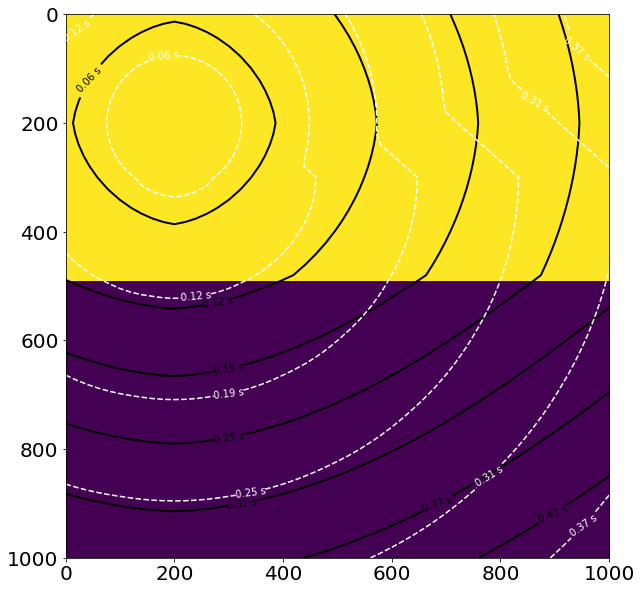

In [117]:
plt.figure(figsize=(15,10))

extent=(x.min(), x.max(), z.min(), z.max())

plt.imshow(V.T, extent=(xmin,xmax,zmax,zmin))

levels = np.linspace(T_FSM.min(), T_FSM.max(), 9)

cs1 = plt.contour(T_FSM.T, extent=extent, levels=levels, colors='k', linewidths=2)
plt.clabel(cs1, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
# plt.quiver(X_, Z_, U_1, V_1, scale=20, color='k', ls='-')

cs2 = plt.contour(T_true.T, extent=extent, levels=levels, colors='w', linestyles='--')
plt.clabel(cs2, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
# plt.quiver(X_, Z_, U_2, V_2, scale=20, color='w', ls='-')

plt.ylim([z.max(), z.min()])
plt.axis('scaled')

plt.show()

## Model with 2 layer (high, low)

In [7]:
nx, nz = 51, 51
xmin, xmax = 0, 1000
zmin, zmax = 0, 1000
frames = np.array([xmin, xmax, zmin, zmax])
scaler = max(abs(frames))

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
X, Z = np.meshgrid(x, z, indexing='ij')

vmin, vmax = 2000.0, 3000.0
izc = 25
V = np.full_like(Z, vmax)
V[:, izc:] = vmin
# V = gaussian_filter(V, 3)

In [8]:
ixs, izs = 10, 10
xs, zs = X[ixs, izs], Z[ixs, izs]
sou = [xs, zs]
V_scaled = V / V.max()
X_shift, Z_shift = X - xs, Z - zs
X_scaled, Z_scaled = X_shift / scaler, Z_shift / scaler

R = np.linalg.norm(np.stack([X_scaled, Z_scaled], axis=-1), axis=-1)
B = np.full_like(R, -1.0)
B[R == 0] = 0.0

In [9]:
CoordLimLow = np.array([xmin, zmin])
CoordLimHigh = np.array([xmax, zmax])
GridSize = np.array([nx, nz])
GridStep = (CoordLimHigh - CoordLimLow) / (GridSize - 1)

T_FSM = ost.LSM2D(V, CoordLimLow, CoordLimHigh, GridStep, sou)

In [84]:
dx = x[1] - x[0]
dz = z[1] - z[0]
grad_x, grad_z = np.gradient(T_FSM, dx, dz)
grad = np.stack([grad_x, grad_z], axis=-1)

grad_norm = grad / np.linalg.norm(grad, axis=-1, keepdims=True) + 1e-16

data_inhomo = prepare_inputs([X_scaled.ravel(), Z_scaled.ravel(), V_scaled.ravel(), B.ravel(), T_FSM], 
                             ['input_x', 'input_y', 'velocity', 'bounds', 'true'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


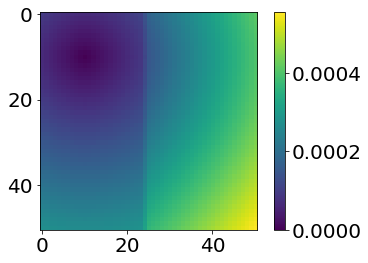

In [33]:
dot = grad_x * X_scaled + grad_z * Z_scaled

plt.imshow(dot)
plt.colorbar()

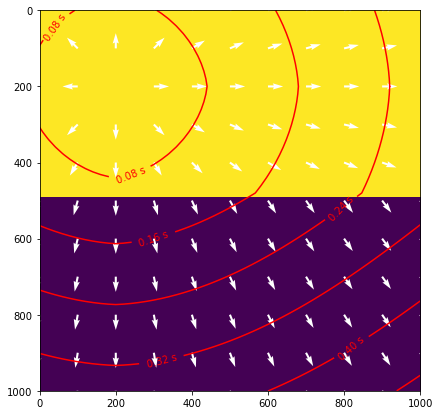

In [11]:
step = 5

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_ = grad_norm[::step, ::step, 0]
V_ = -grad_norm[::step, ::step, 1]

plt.figure(figsize=(15,10))

extent=(xmin, xmax, zmin, zmax)

plt.subplot(121)
plt.imshow(V.T, extent=(xmin, xmax, zmax, zmin))
cs = plt.contour(T_FSM.T, colors='r', extent=extent)
# plt.colorbar(mappable=img, ax=ax, fraction=1/22)
plt.clabel(cs, cs.levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
plt.ylim([zmax, zmin])
plt.quiver(X_, Z_, U_, V_, scale=25, color='white')
plt.axis('scaled')

plt.show()

In [14]:
data, indices = expansion_batches(arrays=[X_scaled, Z_scaled, V_scaled, B], 
                                  names=['input_x', 'input_y', 'velocity', 'bounds'],
                                  center=(ixs, izs), step_i=2, step_j=2, start=1)

In [93]:
model_t, model_eikonal, model_vectorfield = eikonal.init_model(
                                    nh=50, layers=3, shape=(1,), activation='tanh', 
                                    lr=5e-4, decay=-1e-5, init='glorot_normal', 
                                    include_velocity=False, blambda1=2.0, blambda2=0.0, blambda3=0.0, 
                                    monotonity_dxy=False, monotonity_v=True, mlambda1=3.0, mlambda2=0.0)
model_eikonal.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_y (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenate_28 (Concatenate)    (None, 2)            0           input_x[0][0]                    
                                                                 input_y[0][0]                    
__________________________________________________________________________________________________
dense_82 (Dense)                (None, 50)           150         concatenate_28[0][0]             
__________

1089
MAE = 30.272 ms, 16.08 %


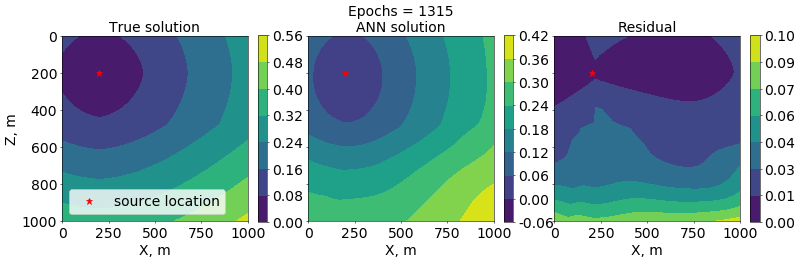

KeyboardInterrupt: 

In [92]:
%%time
input_test = data_inhomo
T_true = T_FSM

epochs = np.linspace(2500, 250, len(data), dtype=int)
# epochs = 10
M = model_eikonal
k = 1
for i in range(0, len(data)):
    input_train = data[k*i]
    output_train = data[k*i]['bounds']
#     input_train = data_inhomo
#     output_train = data_inhomo['bounds']
    batch_size = len(output_train)


    M.fit(
        input_train, 
        output_train, 
        batch_size=batch_size,
        epochs=epochs[k*i],
        shuffle=True,
        validation_split=.0,
        verbose=0,
#         callbacks=[plot_losses]
    )

    clear_output(wait=True)
    T_pred = model_t.predict(input_test) / V.max() * scaler
    T_pred_2d = T_pred.reshape(T_true.shape)
    print(batch_size)
    MAE = abs(T_pred_2d - T_true)
    rMAE = MAE / (T_true + 1e-16) * 100
    if rMAE[ixs, izs] != 0.0:
        rMAE[ixs, izs] = 100
        
    print('MAE = {0:.3f} ms, {1:.2f} %'.format(MAE.mean() * 1000, rMAE.mean()))
    fig, axes = plot_utils.plot_images(imgs=[[T_FSM.T, T_pred_2d.T, MAE.T]], 
                            cols_names=[['True solution', 'Epochs = {}\nANN solution'.format(epochs[k*i]), 'Residual']], 
                            sources=[[sou, sou, sou]], extent=(xmin,xmax,zmin,zmax), source_size=10, figsize = (18, 12),  
                            fontsize=20, imshows=False, colorbars=True)

    plt.show()

In [68]:
pred_grad = model_vectorfield.predict(input_test) / V.max()
pred_grad = pred_grad.reshape(T_pred_2d.shape + (2,))
pred_modul = np.linalg.norm(pred_grad, axis=-1, keepdims=True) + 1e-16
pred_grad_norm = pred_grad / pred_modul

step = 2

X_ = X[::step, ::step]
Z_ = Z[::step, ::step]
U_1 = grad[::step, ::step, 0]
V_1 = -grad[::step, ::step, 1]

U_2 = pred_grad_norm[::step, ::step, 0]
V_2 = -pred_grad_norm[::step, ::step, 1]

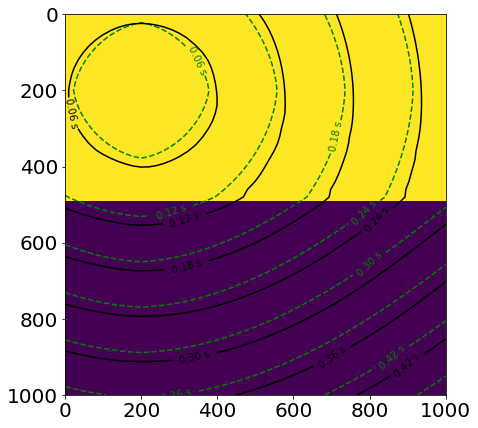

In [78]:
plt.figure(figsize=(15,10))

extent=(xmin, xmax, zmin, zmax)

levels = np.linspace(T_pred_2d.min(), T_pred_2d.max(), 9)

plt.subplot(121)
plt.imshow(V.T, extent=(xmin, xmax, zmax, zmin))
cs1 = plt.contour(T_FSM.T, colors='g', linestyles='--', extent=extent, levels=levels)
cs2 = plt.contour(T_pred_2d.T, colors='k', extent=extent, levels=levels)

plt.clabel(cs1, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
plt.clabel(cs2, levels, inline=True, inline_spacing=5, fmt='%.2f s', fontsize=10)
plt.ylim([zmax, zmin])

plt.axis('scaled')

plt.show()

<hr>

In [ ]:
MAE = abs(T_pred_2d - tau)
rMAE = MAE / (tau + 1e-16) * 100
rMAE[ixs, izs] = MAE[ixs, izs]

In [ ]:
imgs = [[V.T / 1000, tau.T, T_pred_2d.T]]
quiver = [[None, [X_, Z_, U_1, V_1], [X_, Z_, U_2, V_2]]]
sources = [[sou, sou, sou, sou, sou]]
cols_names = [['Velocity model', 'Analytical solution', 'Neural network solution', 'Relative absolute error of traveltimes', 'Relative error of gradient']]
imshows = [[True, False, False, True, True]]
colorbars = True
cbar_labels = [['velocity, km/s', 'traveltime, sec', 'traveltime, sec', 'traveltime error, %', 'gradient error, %']]
figsize = (35, 20)
fontsize = 25

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, quiver=quiver, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        sources=sources, extent=(xmin,xmax,zmin,zmax), source_size=15, figsize=figsize, fontsize=fontsize,)

plt.show()

In [ ]:
imgs = [[rMAE.T, r_diff_grad.T]]
quiver = None
sources = np.array(sou)
cols_names = [['Relative absolute error of traveltimes', 'Relative error of gradient']]
imshows = True
colorbars = True
cbar_labels = [['traveltime error, %', 'gradient error, %']]
figsize = (22, 15)
fontsize = 25
extent=(xmin,xmax,zmin,zmax)

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, quiver=quiver, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        sources=sources, extent=extent, source_size=15, figsize=figsize, fontsize=fontsize,legend=False)

plt.show()

In [ ]:
extent = (x.min(), x.max(), z.min(), z.max())

mae = abs(tau - T_pred_2d) / tau * 100
mae[ixs, izs] = 0
# mae2 = abs(tau - result[1]) / (tau + 1e-16) * 100

fsm = FSM[ixs,izs]
fsm_mae = abs(tau - fsm) / (tau + 1e-16) * 100

imgs = [[tau.T * 1000, fsm.T * 1000, fsm_mae.T], 
        [tau.T * 1000, T_pred_2d.T * 1000, mae.T]]

cols_names = [['Аналитическое решение', 'Решение FSM', 'Относительна ошибка, mae {0:.2f} %'.format(fsm_mae.mean())], 
              ['Аналитическое решение', 'Решение нейронной сети', 'Относительна ошибка, mae {0:.2f} %'.format(mae.mean())]]

imshows = False
colorbars = [[True, True, True], 
             [True, True, True], 
             [True, True, True]]
cbar_labels = [['время, мс', 'время, мс', 'ошибка, %'], 
               ['время, мс', 'время, мс', 'ошибка, %']]

sources = [[sou, sou, sou],[sou, sou, sou]]
source_label = 'положение источника'

fig, axes = plot_utils.plot_images(imgs=imgs, cols_names=cols_names, imshows=imshows, colorbars=colorbars, cbar_labels=cbar_labels,
                        figsize=(25,14), extent=extent, sources=sources, source_label=source_label,
                        source_size=12)

plt.show()

In [ ]:
N = 13
plt.figure(figsize=(12,6))
plt.plot(T_true[:,N], '-*r', label='True')
plt.plot(T_pred_2d[:,N])
plt.legend(loc='best')
plt.show()

In [ ]:
imags = []

indices = [(0,1), (0,2)]
for i in range(0, end):
    imag = np.concatenate((pred_u[:, i], mae[:, i]), axis=0)
    print(imag.shape)
    ims = update_images(axes, imgs=imag, indices=indices, extent=(0,2000,0,2000))
    imags.append(ims)

anim = anm.ArtistAnimation(fig, imags, interval=150, blit=True, repeat = True)

anim.save('eikonal_vgrad.gif', dpi=50, writer='imagemagick')

In [ ]:
batches, c_indexes, s_indexes = discretization_crest(X.squeeze(), 
                                                     nearest_up=1, nearest_down=1, 
                                                     nearest_left=2, nearest_right=2,
                                                     step_i=5, step_j=6)

In [ ]:
arr_s_indexes = np.array(s_indexes)
arr_c_indexes = np.array(c_indexes)

print(batches[0])

print([X.squeeze()[ind] for ind in s_indexes[0]])

In [ ]:
M = np.arange(0, 48)
plt.figure(figsize=(10,10))
plt.imshow(V.squeeze())
for m in M:
    plt.scatter(arr_s_indexes[m,:,1], arr_s_indexes[m,:,0], marker='o', s=10)
    plt.scatter(arr_c_indexes[m,1], arr_c_indexes[m,0], marker='*', c='k', s=25)
plt.show()

In [ ]:
x = np.linspace(-4, 5, 51)
y = np.linspace(-3, 6, 51)
X, Y = np.meshgrid(x, y, indexing = 'ij')

batches, indices = expansion_batches(arrays=[X, Y], names=['X', 'Y'], center=(4,3), step_i=1, step_j=1)


In [ ]:
arr_indices = np.array(indices)

In [ ]:
arr_indices[5][:][0]

In [ ]:
M = 46
plt.figure(figsize=(6,6))
plt.imshow(np.ones((51, 51)))
for arr in arr_indices[M]:
    plt.plot(arr[0], arr[1], '.k')
plt.plot(25, 25, '*r', ms=12)
plt.show()